Regression_ age + Face prediction 

In [3]:
import os
import json
import cv2
import torch
import numpy as np

from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

In [4]:
def collect_image_age_pairs(image_root_dir, json_root_dir):
    pairs = []

    # subject_id dir 반복
    subject_ids = sorted([d for d in os.listdir(image_root_dir) if os.path.isdir(os.path.join(image_root_dir, d))])

    print(f"총 subject 수: {len(subject_ids)}")

    for subject_id in subject_ids:
        subject_image_dir = os.path.join(image_root_dir, subject_id)
        subject_json_dir = os.path.join(json_root_dir, subject_id)
        if not os.path.exists(subject_json_dir):
            print(f"[경고] JSON 디렉토리 없음: {subject_json_dir}")
            continue
        
        #이미지 파일 중 Jpg만 추출 
        jpg_files = [f for f in os.listdir(subject_image_dir) if f.endswith('.jpg')]

        for jpg_file in jpg_files:
            base_name = jpg_file.replace('.jpg', '')    
            json_filename = f"{base_name}_00.json"
            json_path = os.path.join(subject_json_dir, json_filename)
            jpg_path = os.path.join(subject_image_dir, jpg_file)

            if os.path.exists(json_path):
                try:
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        age = data['info']['age'] #info[4]
                        pairs.append((jpg_path, age))
                        
                except Exception as e:
                    print(f"[오류] JSON 파싱 실패: {json_path} - {e}")
            else:
                print(f"[경고] JSON 파일 없음: {json_path}")

    return pairs

In [5]:
# 루트 경로 설정  
image_root = '/home/alpaco/yskim/data/Training/origin/digitalCamera'
json_root = '/home/alpaco/yskim/data/Training/lable/digitalCamera'

# 실행 
image_age_pairs = collect_image_age_pairs(image_root, json_root)

# 결과
print(f"총 매칭 이미지 수: {len(image_age_pairs)}")
print("샘플 10:")
for i in range(min(10, len(image_age_pairs))):
    print(image_age_pairs[i])

총 subject 수: 858
총 매칭 이미지 수: 6006
샘플 10:
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_L15.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_Fb.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_L30.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_Ft.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_F.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_R15.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_R30.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_Fb.jpg', 24)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_F.jpg', 24)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_L15.jpg', 24)


In [6]:
import pandas as pd

df = pd.DataFrame(image_age_pairs, columns=['image_path', 'age'])
print(df.head())

                                          image_path  age
0  /home/alpaco/yskim/data/Training/origin/digita...   50
1  /home/alpaco/yskim/data/Training/origin/digita...   50
2  /home/alpaco/yskim/data/Training/origin/digita...   50
3  /home/alpaco/yskim/data/Training/origin/digita...   50
4  /home/alpaco/yskim/data/Training/origin/digita...   50


### EfficientNet 학습
1. data준비
2. custom dataset 클래스 정의
3. 이미지 전처리(transforms)
4. 모델 구성 (ResNet, EfficientNet)
5. Regression Loss (MSELoss)
6. 학습루프 작성(Train/val)
7. 성능평가(MAE, RMSE)

In [7]:
!pip install torch torchvision pandas scikit-learn timm pandas

In [8]:
# Dataset 정의 
class AgeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        image = Image.open(img_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image)
    
        return image, torch.tensor(age, dtype=torch.float32)

In [9]:
!pip install scikit-image

In [10]:
!pip install --upgrade gdown

  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.3
    Uninstalling gdown-4.6.3:
      Successfully uninstalled gdown-4.6.3


In [11]:
!pip install gdown==v4.6.3

  Using cached gdown-4.6.3-py3-none-any.whl.metadata (4.4 kB)
Using cached gdown-4.6.3-py3-none-any.whl (14 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [12]:
from skimage import io, exposure, img_as_ubyte
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

In [13]:
# Horizontal Equalizing
image_root = '/home/alpaco/yskim/data/Training/origin/digitalCamera'
output_folder = '/home/alpaco/yskim/data/Training/CLAHE/digitalCamera'
os.makedirs(output_folder, exist_ok=True)

image_files = [f for f in os.listdir(image_root) if f.lower().endswith('.jpg')]

for file in image_files:
    image_path = os.path.join(image_root, file)
    image = io.imread(image_path)

    if image.ndim == 3:
        image_gray = rgb2gray(image)
    else:
        image_gray = image

    equalized = exposure.equalize_adapthist(image_gray, clip_limit=0.03)
    output_path = os.path.join(output_folder, f'equalized_{file}')
    io.imsave(output_path, img_as_ubyte(equalized))
    print(f"Saved: {output_path}")

In [14]:
# Custom Data

class AgeRegressionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age, dtype=torch.float32)

In [15]:
# transform 정의 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [16]:
# dataloader 구성
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

df = pd.DataFrame(image_age_pairs, columns=['image_path', 'age'])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = AgeDataset(train_df, transform=transform)
val_dataset = AgeDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
#EfficientNet
import torch.nn as nn
import timm  

class EfficientNetRegressor(nn.Module):
    def __init__(self):
        super(EfficientNetRegressor, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, 1)  # 회귀용 출력
        
    def forward(self, x):
        return self.backbone(x).squeeze(1)

/home/alpaco/anaconda3/envs/alpacosry/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# 학습루프 
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import ImageFile
from skimage import io, exposure, img_as_ubyte
from skimage.color import rgb2gray

ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetRegressor().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 결과 저장 리스트 ---
train_loss_history = []
train_mae_history = []
train_rmse_history = []

val_loss_history = []
val_mae_history = []
val_rmse_history = []

for epoch in range(30):
    # ----- Train -----
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []

    for images, ages in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        images, ages = images.to(device), ages.to(device)

        preds = model(images).squeeze()
        loss = criterion(preds, ages.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(ages.detach().cpu().numpy())

    avg_loss = train_loss / len(train_loader.dataset)
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    train_loss_history.append(avg_loss)
    train_mae_history.append(mae)
    train_rmse_history.append(rmse)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    # ----- Validation -----
    model.eval()
    total_loss = 0.0
    true_ages, pred_ages = [], []

    with torch.no_grad():
        for images, ages in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation"):
            images = images.to(device)
            ages = ages.to(device)

            preds = model(images).squeeze()
            loss = criterion(preds, ages.float())

            total_loss += loss.item() * images.size(0)
            true_ages.extend(ages.detach().cpu().numpy())
            pred_ages.extend(preds.detach().cpu().numpy())

    val_avg_loss = total_loss / len(val_loader.dataset)
    v_mae = mean_absolute_error(true_ages, pred_ages)
    v_rmse = mean_squared_error(true_ages, pred_ages, squared=False)

    val_loss_history.append(val_avg_loss)
    val_mae_history.append(v_mae)
    val_rmse_history.append(v_rmse)

    print(f"[Epoch {epoch+1}] Val Loss: {val_avg_loss:.4f} | MAE: {v_mae:.4f} | RMSE: {v_rmse:.4f}")

[Epoch 1] Training: 100%|██████████| 151/151 [13:58<00:00,  5.56s/it]


[Epoch 1] Train Loss: 326.8273 | MAE: 13.0642 | RMSE: 18.0784


[Epoch 1] Validation: 100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


[Epoch 1] Val Loss: 128.4921 | MAE: 6.0901 | RMSE: 11.3354


[Epoch 2] Training: 100%|██████████| 151/151 [13:36<00:00,  5.41s/it]


[Epoch 2] Train Loss: 31.2796 | MAE: 4.1022 | RMSE: 5.5928


[Epoch 2] Validation: 100%|██████████| 38/38 [01:56<00:00,  3.05s/it]


[Epoch 2] Val Loss: 31.3951 | MAE: 4.2742 | RMSE: 5.6031


[Epoch 3] Training: 100%|██████████| 151/151 [13:18<00:00,  5.29s/it]


[Epoch 3] Train Loss: 18.3032 | MAE: 3.3008 | RMSE: 4.2782


[Epoch 3] Validation: 100%|██████████| 38/38 [01:55<00:00,  3.03s/it]


[Epoch 3] Val Loss: 46.4560 | MAE: 5.2909 | RMSE: 6.8159


[Epoch 4] Training: 100%|██████████| 151/151 [13:23<00:00,  5.32s/it]


[Epoch 4] Train Loss: 15.0533 | MAE: 2.9611 | RMSE: 3.8799


[Epoch 4] Validation: 100%|██████████| 38/38 [01:52<00:00,  2.96s/it]


[Epoch 4] Val Loss: 21.8321 | MAE: 2.5854 | RMSE: 4.6725


[Epoch 5] Training: 100%|██████████| 151/151 [13:31<00:00,  5.38s/it]


[Epoch 5] Train Loss: 12.4754 | MAE: 2.6935 | RMSE: 3.5321


[Epoch 5] Validation: 100%|██████████| 38/38 [01:56<00:00,  3.07s/it]


[Epoch 5] Val Loss: 33.7496 | MAE: 3.3181 | RMSE: 5.8094


[Epoch 6] Training: 100%|██████████| 151/151 [13:15<00:00,  5.27s/it]


[Epoch 6] Train Loss: 11.7757 | MAE: 2.6129 | RMSE: 3.4316


[Epoch 6] Validation: 100%|██████████| 38/38 [01:51<00:00,  2.95s/it]


[Epoch 6] Val Loss: 19.0028 | MAE: 3.2543 | RMSE: 4.3592


[Epoch 7] Training: 100%|██████████| 151/151 [13:07<00:00,  5.22s/it]


[Epoch 7] Train Loss: 14.2142 | MAE: 2.9237 | RMSE: 3.7702


[Epoch 7] Validation: 100%|██████████| 38/38 [01:59<00:00,  3.16s/it]


[Epoch 7] Val Loss: 10.6744 | MAE: 2.5392 | RMSE: 3.2672


[Epoch 8] Training: 100%|██████████| 151/151 [13:38<00:00,  5.42s/it]


[Epoch 8] Train Loss: 13.8681 | MAE: 2.9501 | RMSE: 3.7240


[Epoch 8] Validation: 100%|██████████| 38/38 [02:10<00:00,  3.43s/it]


[Epoch 8] Val Loss: 15.6719 | MAE: 2.8998 | RMSE: 3.9588


[Epoch 9] Training: 100%|██████████| 151/151 [13:27<00:00,  5.35s/it]


[Epoch 9] Train Loss: 10.4432 | MAE: 2.5338 | RMSE: 3.2316


[Epoch 9] Validation: 100%|██████████| 38/38 [01:53<00:00,  2.97s/it]


[Epoch 9] Val Loss: 9.2101 | MAE: 2.4235 | RMSE: 3.0348


[Epoch 10] Training: 100%|██████████| 151/151 [13:15<00:00,  5.27s/it]


[Epoch 10] Train Loss: 9.4247 | MAE: 2.4262 | RMSE: 3.0700


[Epoch 10] Validation: 100%|██████████| 38/38 [02:05<00:00,  3.31s/it]


[Epoch 10] Val Loss: 9.0050 | MAE: 2.3661 | RMSE: 3.0008


[Epoch 11] Training: 100%|██████████| 151/151 [13:19<00:00,  5.30s/it]


[Epoch 11] Train Loss: 8.4864 | MAE: 2.2719 | RMSE: 2.9131


[Epoch 11] Validation: 100%|██████████| 38/38 [02:02<00:00,  3.22s/it]


[Epoch 11] Val Loss: 8.9859 | MAE: 2.3663 | RMSE: 2.9976


[Epoch 12] Training: 100%|██████████| 151/151 [13:04<00:00,  5.20s/it]


[Epoch 12] Train Loss: 8.2527 | MAE: 2.2653 | RMSE: 2.8727


[Epoch 12] Validation: 100%|██████████| 38/38 [01:51<00:00,  2.92s/it]


[Epoch 12] Val Loss: 15.3123 | MAE: 3.2232 | RMSE: 3.9131


[Epoch 13] Training: 100%|██████████| 151/151 [13:24<00:00,  5.33s/it]


[Epoch 13] Train Loss: 6.3544 | MAE: 1.9530 | RMSE: 2.5208


[Epoch 13] Validation: 100%|██████████| 38/38 [02:03<00:00,  3.26s/it]


[Epoch 13] Val Loss: 13.3806 | MAE: 2.9555 | RMSE: 3.6580


[Epoch 14] Training: 100%|██████████| 151/151 [13:29<00:00,  5.36s/it]


[Epoch 14] Train Loss: 5.7644 | MAE: 1.8752 | RMSE: 2.4009


[Epoch 14] Validation: 100%|██████████| 38/38 [02:11<00:00,  3.47s/it]


[Epoch 14] Val Loss: 11.9743 | MAE: 2.7945 | RMSE: 3.4604


[Epoch 15] Training: 100%|██████████| 151/151 [13:41<00:00,  5.44s/it]


[Epoch 15] Train Loss: 5.1093 | MAE: 1.7782 | RMSE: 2.2604


[Epoch 15] Validation: 100%|██████████| 38/38 [01:52<00:00,  2.95s/it]


[Epoch 15] Val Loss: 14.3049 | MAE: 3.0775 | RMSE: 3.7822


[Epoch 16] Training: 100%|██████████| 151/151 [13:12<00:00,  5.25s/it]


[Epoch 16] Train Loss: 4.3155 | MAE: 1.6228 | RMSE: 2.0774


[Epoch 16] Validation: 100%|██████████| 38/38 [01:52<00:00,  2.96s/it]


[Epoch 16] Val Loss: 8.1780 | MAE: 2.2300 | RMSE: 2.8597


[Epoch 17] Training: 100%|██████████| 151/151 [13:21<00:00,  5.31s/it]


[Epoch 17] Train Loss: 3.9443 | MAE: 1.5670 | RMSE: 1.9860


[Epoch 17] Validation: 100%|██████████| 38/38 [01:55<00:00,  3.04s/it]


[Epoch 17] Val Loss: 9.1832 | MAE: 2.1357 | RMSE: 3.0304


[Epoch 18] Training: 100%|██████████| 151/151 [13:04<00:00,  5.20s/it]


[Epoch 18] Train Loss: 3.3542 | MAE: 1.4186 | RMSE: 1.8314


[Epoch 18] Validation: 100%|██████████| 38/38 [01:57<00:00,  3.10s/it]


[Epoch 18] Val Loss: 8.5659 | MAE: 2.0701 | RMSE: 2.9267


[Epoch 19] Training: 100%|██████████| 151/151 [13:32<00:00,  5.38s/it]


[Epoch 19] Train Loss: 3.2379 | MAE: 1.3975 | RMSE: 1.7994


[Epoch 19] Validation: 100%|██████████| 38/38 [02:07<00:00,  3.37s/it]


[Epoch 19] Val Loss: 15.3321 | MAE: 2.9883 | RMSE: 3.9156


[Epoch 20] Training: 100%|██████████| 151/151 [13:06<00:00,  5.21s/it]


[Epoch 20] Train Loss: 4.2441 | MAE: 1.6183 | RMSE: 2.0601


[Epoch 20] Validation: 100%|██████████| 38/38 [01:52<00:00,  2.96s/it]


[Epoch 20] Val Loss: 13.2484 | MAE: 2.9621 | RMSE: 3.6398


[Epoch 21] Training: 100%|██████████| 151/151 [13:11<00:00,  5.24s/it]


[Epoch 21] Train Loss: 2.7506 | MAE: 1.2904 | RMSE: 1.6585


[Epoch 21] Validation: 100%|██████████| 38/38 [01:52<00:00,  2.97s/it]


[Epoch 21] Val Loss: 11.3615 | MAE: 2.6868 | RMSE: 3.3707


[Epoch 22] Training: 100%|██████████| 151/151 [13:35<00:00,  5.40s/it]


[Epoch 22] Train Loss: 2.8119 | MAE: 1.3046 | RMSE: 1.6769


[Epoch 22] Validation: 100%|██████████| 38/38 [01:52<00:00,  2.97s/it]


[Epoch 22] Val Loss: 5.9952 | MAE: 1.8594 | RMSE: 2.4485


[Epoch 23] Training: 100%|██████████| 151/151 [13:42<00:00,  5.44s/it]


[Epoch 23] Train Loss: 2.2735 | MAE: 1.1649 | RMSE: 1.5078


[Epoch 23] Validation: 100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


[Epoch 23] Val Loss: 8.1268 | MAE: 2.2156 | RMSE: 2.8508


[Epoch 24] Training: 100%|██████████| 151/151 [13:10<00:00,  5.24s/it]


[Epoch 24] Train Loss: 2.4652 | MAE: 1.2075 | RMSE: 1.5701


[Epoch 24] Validation: 100%|██████████| 38/38 [01:54<00:00,  3.00s/it]


[Epoch 24] Val Loss: 6.8328 | MAE: 2.0580 | RMSE: 2.6140


[Epoch 25] Training: 100%|██████████| 151/151 [13:20<00:00,  5.30s/it]


[Epoch 25] Train Loss: 2.6379 | MAE: 1.2568 | RMSE: 1.6242


[Epoch 25] Validation: 100%|██████████| 38/38 [02:08<00:00,  3.37s/it]


[Epoch 25] Val Loss: 8.8982 | MAE: 2.3221 | RMSE: 2.9830


[Epoch 26] Training: 100%|██████████| 151/151 [13:36<00:00,  5.41s/it]


[Epoch 26] Train Loss: 5.5378 | MAE: 1.8294 | RMSE: 2.3532


[Epoch 26] Validation: 100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


[Epoch 26] Val Loss: 8.1304 | MAE: 2.2185 | RMSE: 2.8514


[Epoch 27] Training: 100%|██████████| 151/151 [13:26<00:00,  5.34s/it]


[Epoch 27] Train Loss: 3.1905 | MAE: 1.3939 | RMSE: 1.7862


[Epoch 27] Validation: 100%|██████████| 38/38 [01:52<00:00,  2.95s/it]


[Epoch 27] Val Loss: 6.5662 | MAE: 1.9827 | RMSE: 2.5625


[Epoch 28] Training: 100%|██████████| 151/151 [13:55<00:00,  5.54s/it]


[Epoch 28] Train Loss: 2.2148 | MAE: 1.1526 | RMSE: 1.4882


[Epoch 28] Validation: 100%|██████████| 38/38 [02:10<00:00,  3.44s/it]


[Epoch 28] Val Loss: 5.8691 | MAE: 1.8737 | RMSE: 2.4226


[Epoch 29] Training: 100%|██████████| 151/151 [13:56<00:00,  5.54s/it]


[Epoch 29] Train Loss: 2.6667 | MAE: 1.2821 | RMSE: 1.6330


[Epoch 29] Validation: 100%|██████████| 38/38 [01:51<00:00,  2.94s/it]


[Epoch 29] Val Loss: 6.0699 | MAE: 1.9029 | RMSE: 2.4637


[Epoch 30] Training: 100%|██████████| 151/151 [13:17<00:00,  5.28s/it]


[Epoch 30] Train Loss: 2.5491 | MAE: 1.2388 | RMSE: 1.5966


[Epoch 30] Validation: 100%|██████████| 38/38 [01:55<00:00,  3.03s/it]

[Epoch 30] Val Loss: 6.3817 | MAE: 1.9469 | RMSE: 2.5262


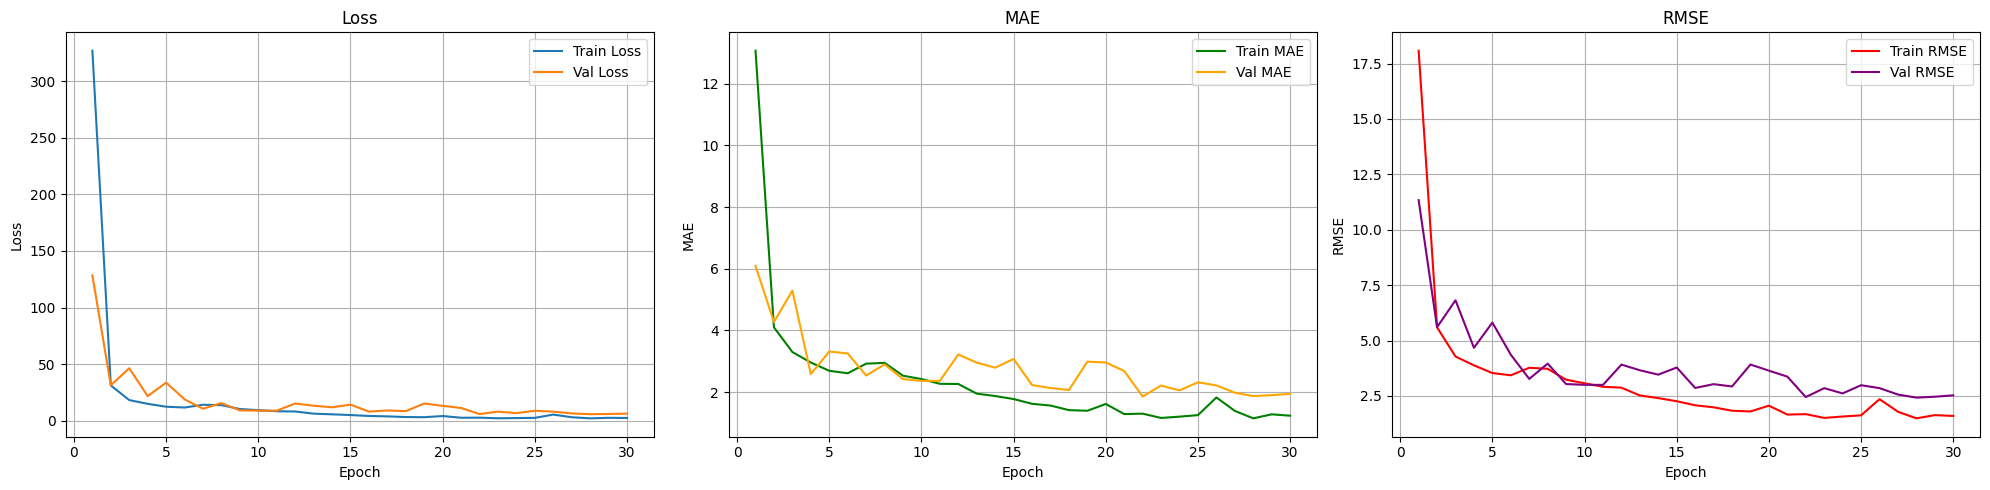

In [20]:
#시각화
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, train_mae_history, label='Train MAE', color='green')
plt.plot(epochs, val_mae_history, label='Val MAE', color='orange')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse_history, label='Train RMSE', color='red')
plt.plot(epochs, val_rmse_history, label='Val RMSE', color='purple')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()